## 1. Feature Extraction  <a name="first-bullet"></a>

In [ ]:
import os

import librosa
import numpy as np
import pandas as pd

from tqdm import tqdm

In [ ]:
import numpy as np
np.float = float
np.complex = complex

# Define constants
HOP_LENGTH = 512        # number of samples between successive frames
WINDOW_LENGTH = 512     # length of the window in samples
N_MEL = 128             # number of Mel bands to generate
N_MFCC = 23             # number of MDCCs to generate

def compute_melspectrogram_with_fixed_length(audio, sampling_rate, num_of_samples=128):
    # Compute a mel-scaled spectrogram
    melspectrogram = librosa.feature.melspectrogram(y=audio, 
                                                    sr=sampling_rate, 
                                                    hop_length=HOP_LENGTH,
                                                    win_length=WINDOW_LENGTH, 
                                                    n_mels=N_MEL)
    # Convert a power spectrogram to decibel units (log-mel spectrogram)
    melspectrogram_db = librosa.power_to_db(melspectrogram, ref=np.max)
    # Pad or fix the length of spectrogram
    melspectrogram_db = librosa.util.fix_length(melspectrogram_db, size=num_of_samples, axis=1)
    return melspectrogram_db

def compute_mfcc_with_fixed_length(audio, sampling_rate, num_of_samples=128):
    # Compute MFCCs
    mfcc = librosa.feature.mfcc(y=audio, sr=sampling_rate, n_mfcc=N_MFCC)
    # Pad or fix the length of MFCC
    mfcc = librosa.util.fix_length(mfcc, size=num_of_samples, axis=1)
    return mfcc

#librosa.util.fix_length(data, size, axis=-1, value=0.0)

# Update the dataset path
dataset_path = "C:\\Users\\patri\\GA3\\US8K\\UrbanSound8K"
metadata_path = os.path.join(dataset_path, "metadata/UrbanSound8K.csv")

# Load metadata
metadata = pd.read_csv(metadata_path)

# Prepare lists of audio file paths, labels, and folds
audio_files = [os.path.join(dataset_path, f"audio/fold{row['fold']}", row['slice_file_name']) for _, row in metadata.iterrows()]
labels = metadata['classID'].tolist()
folds = metadata['fold'].tolist()

# Verify file existence and warn about missing files
valid_audio_files = []
valid_labels = []
valid_folds = []

for audio_file, label, fold in zip(audio_files, labels, folds):
    if os.path.exists(audio_file):
        valid_audio_files.append(audio_file)
        valid_labels.append(label)
        valid_folds.append(fold)
    else:
        print(f"File not found: {audio_file}")

# Update the loop with the verified lists
features = []

for audio_path, label, fold in tqdm(zip(valid_audio_files, valid_labels, valid_folds), total=len(valid_audio_files)):
    try:
        # Load audio file
        audio, sample_rate = librosa.load(audio_path, sr=None)

        # Compute features
        melspectrogram = compute_melspectrogram_with_fixed_length(audio, sample_rate)
        mfcc = compute_mfcc_with_fixed_length(audio, sample_rate)

        # Append features to the list
        features.append([melspectrogram, mfcc, label, fold])
    except Exception as e:
        if "numpy.complex" in str(e):
            print(f"Error: Replace np.complex with complex or np.complex128 in your environment libraries.")
        else:
            print(f"Error processing {audio_path}: {e}")

# Create a DataFrame
us8k_df = pd.DataFrame(features, columns=["melspectrogram", "mfcc", "label", "fold"])

# Save the DataFrame to a pickle file for further processing
us8k_df.to_pickle("us8k_features_with_mfcc.pkl")

## 2. SVM Model with linear kernel  <a name="second-bullet"></a>

In [1]:
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

In [14]:
# Step 1: Load Data
us8k_df = pd.read_pickle("us8k_features_with_mfcc.pkl")

# Step 2: Feature and Label Separation
X = np.array([
    np.concatenate(
        [np.mean(spec, axis=1), np.mean(mfcc, axis=1)]
    )
    for spec, mfcc in zip(us8k_df["melspectrogram"], us8k_df["mfcc"])
])  # Combine spectrograms and MFCCs
y = us8k_df["label"]

# Step 3: Split Data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Step 4: Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 5: Train SVM Model
svm_model = SVC(kernel="linear", random_state=42)
svm_model.fit(X_train, y_train)

# Step 6: Test Model
y_pred = svm_model.predict(X_test)

# Step 7: Evaluate Model
print("Classification report:")
print(classification_report(y_test, y_pred))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

Classification report:
              precision    recall  f1-score   support

           0       0.67      0.85      0.75       200
           1       0.78      0.79      0.79        86
           2       0.66      0.66      0.66       200
           3       0.71      0.70      0.71       200
           4       0.69      0.72      0.71       200
           5       0.84      0.81      0.82       200
           6       0.91      0.64      0.75        75
           7       0.86      0.80      0.83       200
           8       0.86      0.84      0.85       186
           9       0.72      0.66      0.68       200

    accuracy                           0.75      1747
   macro avg       0.77      0.75      0.75      1747
weighted avg       0.76      0.75      0.75      1747

Confusion matrix:
[[171   2   8   1   5   4   0   5   1   3]
 [  3  68   1   0   5   2   1   0   0   6]
 [ 14   2 132   8   7   9   0   2   5  21]
 [  9   5  13 141   9   7   3   0   6   7]
 [  6   3  12  15 145   0   

In [15]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.5f}")

Accuracy: 0.75215


## 3. Grid Search for RBF kernel  <a name="third-bullet"></a>

In [4]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1e-3, 1e-2, 1e-1, 1],
    'kernel': ['rbf']
}

# Initialize the model
svm_model = SVC()

# Perform grid search
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy', verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   8.4s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   8.3s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   8.2s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   8.2s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   8.5s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   7.3s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   7.0s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   6.9s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   6.8s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   7.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  10.4s
[CV] END .......................C=0.1, gamma=0.

## 4. SVM model with RBF kernel  <a name="forth-bullet"></a>

In [5]:
# Step 1: Load Data
us8k_df = pd.read_pickle("us8k_features_with_mfcc.pkl")

# Step 2: Feature and Label Separation
X = np.array([
    np.concatenate(
        [np.mean(spec, axis=1), np.mean(mfcc, axis=1)]
    )
    for spec, mfcc in zip(us8k_df["melspectrogram"], us8k_df["mfcc"])
])  # Combine spectrograms and MFCCs
y = us8k_df["label"]

# Step 3: Split Data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Step 4: Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 5: Train SVM Model
svm_model = SVC(C=10, kernel="rbf", gamma=0.01, random_state=42)
svm_model.fit(X_train, y_train)

# Step 6: Test Model
y_pred = svm_model.predict(X_test)

# Step 7: Evaluate Model
print("Classification report:")
print(classification_report(y_test, y_pred))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

Classification report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       200
           1       0.94      0.85      0.89        86
           2       0.77      0.83      0.80       200
           3       0.82      0.82      0.82       200
           4       0.90      0.89      0.90       200
           5       0.94      0.94      0.94       200
           6       0.89      0.84      0.86        75
           7       0.95      0.92      0.93       200
           8       0.96      0.95      0.95       186
           9       0.81      0.81      0.81       200

    accuracy                           0.89      1747
   macro avg       0.89      0.88      0.89      1747
weighted avg       0.89      0.89      0.89      1747

Confusion matrix:
[[191   0   5   0   0   0   0   2   0   2]
 [  1  73   4   2   2   0   1   1   0   2]
 [  3   0 166   7   1   4   0   0   2  17]
 [  3   3   7 165   3   4   5   1   2   7]
 [  1   1   4   6 178   2   

In [13]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.5f}")

Accuracy: 0.88552


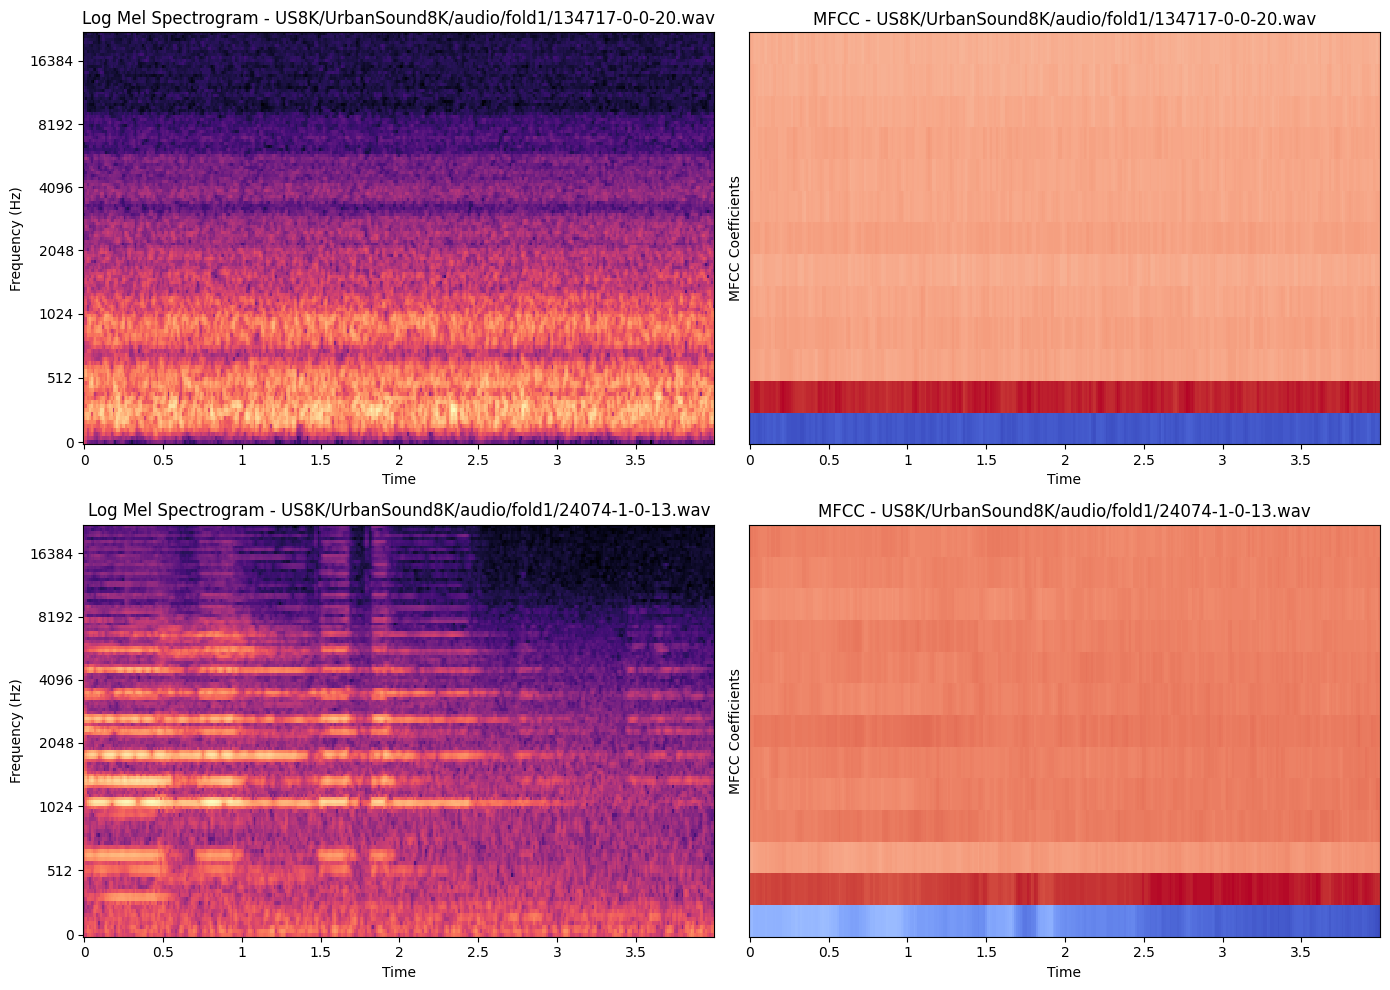

In [16]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

def visualize_audio_features(audio_path1, audio_path2):
    # Function to load audio and visualize features
    def plot_features(audio_path, ax1, ax2):
        # Load the audio file
        y, sr = librosa.load(audio_path, sr=None)

        # Compute log Mel spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

        # Compute MFCC
        mfcc = librosa.feature.mfcc(S=log_mel_spectrogram, sr=sr, n_mfcc=13)

        # Plot log Mel spectrogram
        librosa.display.specshow(log_mel_spectrogram, sr=sr, x_axis='time', y_axis='mel', ax=ax1)
        ax1.set(title="Log Mel Spectrogram", xlabel="Time", ylabel="Frequency (Hz)")

        # Plot MFCC
        librosa.display.specshow(mfcc, sr=sr, x_axis='time', ax=ax2)
        ax2.set(title="MFCC", xlabel="Time", ylabel="MFCC Coefficients")

    # Create subplots for the two audio files
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))

    # Visualize features for the first audio file
    plot_features(audio_path1, axs[0, 0], axs[0, 1])
    axs[0, 0].set_title(f"Log Mel Spectrogram - {audio_path1}")
    axs[0, 1].set_title(f"MFCC - {audio_path1}")

    # Visualize features for the second audio file
    plot_features(audio_path2, axs[1, 0], axs[1, 1])
    axs[1, 0].set_title(f"Log Mel Spectrogram - {audio_path2}")
    axs[1, 1].set_title(f"MFCC - {audio_path2}")

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

# Paths to your audio files
audio_file1 = 'US8K/UrbanSound8K/audio/fold1/134717-0-0-20.wav'
audio_file2 = 'US8K/UrbanSound8K/audio/fold1/24074-1-0-13.wav'

# Call the function to visualize
visualize_audio_features(audio_file1, audio_file2)